{('Fiesta ', 2002.0): 1020.0, ('Fiesta ', 2003.0): 1020.0, ('Fiesta ', 2004.0): 1020.0, ('Fiesta ', 2005.0): 1045.0, ('Fiesta ', 2006.0): 1045.0, ('Fiesta ', 2007.0): 1045.0, ('Fiesta ', 2008.0): 979.0, ('Fiesta ', 2009.0): 979.0, ('Fiesta ', 2010.0): 979.0, ('Fiesta ', 2011.0): 979.0, ('Fiesta ', 2012.0): 979.0, ('Fiesta ', 2013.0): 1045.0, ('Fiesta ', 2014.0): 1045.0, ('Fiesta ', 2015.0): 1045.0, ('Fiesta ', 2016.0): 1045.0, ('Fiesta ', 2017.0): 1166.0, ('Fiesta ', 2018.0): 1166.0, ('Fiesta ', 2019.0): 1166.0, ('Fiesta ', 2020.0): 1166.0, ('Fiesta ', 2021.0): 1166.0, ('Fiesta ', 2022.0): 1166.0, ('Kuga', 2008.0): 1548.0, ('Kuga', 2009.0): 1548.0, ('Kuga', 2010.0): 1548.0, ('Kuga', 2011.0): 1548.0, ('Kuga', 2012.0): 1479.0, ('Kuga', 2013.0): 1479.0, ('Kuga', 2014.0): 1479.0, ('Kuga', 2015.0): 1479.0, ('Kuga', 2016.0): 1504.0, ('Kuga', 2017.0): 1504.0, ('Kuga', 2018.0): 1504.0, ('Kuga', 2019.0): 1579.0, ('Kuga', 2020.0): 1579.0, ('Kuga', 2021.0): 1579.0, ('Kuga', 2022.0): 1579.0, ('Ast

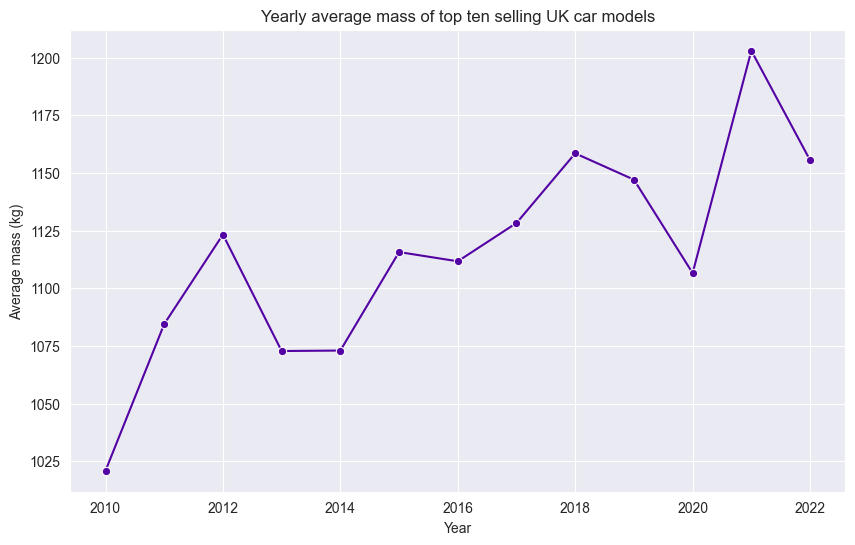

In [13]:
# Yearly average mass of top ten car models

# Load the car model and weight information from Sheet 2
weight_df = pd.read_excel('Car_stats.xlsx', sheet_name='Car weight and CO2')

# Create a dictionary that maps (Model, Year) to Weight
car_weights = {(model, year): weight for model, year, weight in zip(weight_df['Model'], weight_df['Year'], weight_df['Weight kg'])}

# Load the sales data from Sheet 1
sales_df = pd.read_excel('Car_stats.xlsx', sheet_name='Top 10 sold')

# Initialize a dictionary to store the results
yearly_average_weights = {}

# Iterate through the year columns
for year in range(2010, 2023):
    total_weight = 0
    total_cars = 0

    # Iterate through the rows
    for index, row in sales_df.iterrows():
        brand = row['Brand']
        model = row['Model']

        # Check if the year column has a non-null value
        if not pd.isna(row[year]):
            # Get the weight using both model and year
            weight = car_weights.get((model, year), 0)
            total_weight += weight
            total_cars += 1

    # Calculate the average weight for the year
    if total_cars > 0:
        average_weight = total_weight / total_cars
        yearly_average_weights[year] = average_weight


# Print the yearly average weights
for year, weight in yearly_average_weights.items():
    print(f'Year {year}: Average Weight = {weight:.2f} kg')

# Create a DataFrame from the dictionary for plotting
average_weight_df = pd.DataFrame(list(yearly_average_weights.items()), columns=['Year', 'Average Weight'])

# Plot the data
plt.figure(figsize=(10, 6))

sns.lineplot(data=average_weight_df, x='Year', y='Average Weight', marker='o')
plt.title('Yearly average mass of top ten selling UK car models')
plt.xlabel('Year')
plt.ylabel('Average mass (kg)')
plt.grid(True)
plt.show()


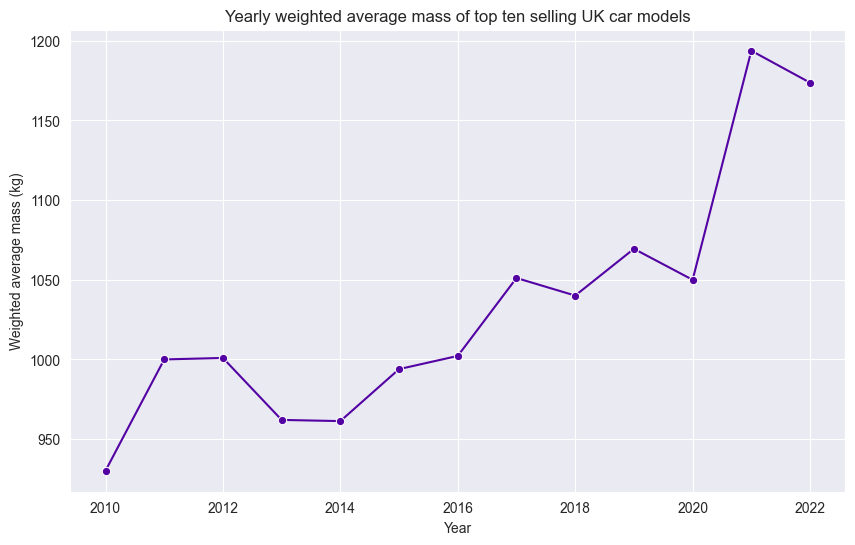

In [5]:
# Weighted average car mass by year

# Load the car model and weight information from Sheet 2
weight_df = pd.read_excel('Car_stats.xlsx', sheet_name='Car weight and CO2')

# Create a dictionary that maps (Model, Year) to Weight
car_weights = {(model, year): weight for model, year, weight in zip(weight_df['Model'], weight_df['Year'], weight_df['Weight kg'])}

# Load the sales data from Sheet 1
sales_df = pd.read_excel('Car_stats.xlsx', sheet_name='Top 10 sold')

# Initialize a dictionary to store the results
yearly_weighted_averages = {}

# Iterate through the year columns
for year in range(2010, 2023):
    total_weighted_sum = 0
    total_cars_sold = 0

    # Iterate through the rows
    for index, row in sales_df.iterrows():
        model = row['Model']

        # Check if the year column has a non-null value
        if not pd.isna(row[year]):
            # Get the weight using both model and year
            weight = car_weights.get((model, year), 0)
            cars_sold = row[year]  # Number of cars sold for this model in this year
            total_weighted_sum += weight * cars_sold
            total_cars_sold += cars_sold

    # Calculate the weighted average weight for the year
    if total_cars_sold > 0:
        weighted_average_weight = total_weighted_sum / total_cars_sold
        yearly_weighted_averages[year] = weighted_average_weight

# Create a DataFrame from the dictionary for plotting
weighted_average_df = pd.DataFrame(list(yearly_weighted_averages.items()), columns=['Year', 'Weighted Average Weight'])

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=weighted_average_df, x='Year', y='Weighted Average Weight', marker='o')
plt.title('Yearly weighted average mass of top ten selling UK car models')
plt.xlabel('Year')
plt.ylabel('Weighted average mass (kg)')
plt.grid(True)
plt.show()


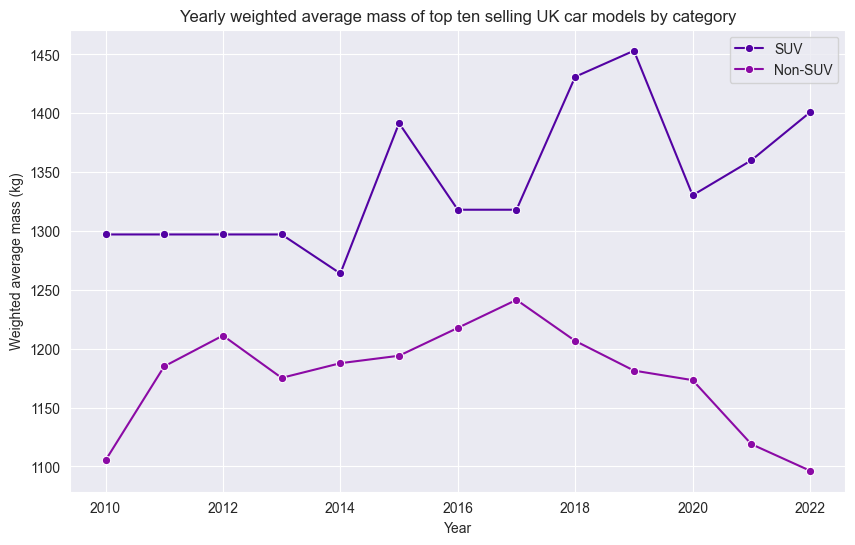

In [ ]:
# Weighted average car mass by year, split SUV and non-SUV

# Load the car model, weight, and SUV information from Sheet 2
weight_df = pd.read_excel('Car_stats.xlsx', sheet_name='Car weight and CO2')

# Create a dictionary that maps (Model, Year) to Weight
car_weights = {(model, year): weight for model, year, weight in zip(weight_df['Model'], weight_df['Year'], weight_df['Weight kg'])}

# Load the sales data from Sheet 1
sales_df = pd.read_excel('Car_stats.xlsx', sheet_name='Top 10 sold')

# Initialize dictionaries to store the results for SUVs and non-SUVs
yearly_suv_weighted_averages = {}
yearly_non_suv_weighted_averages = {}

# Iterate through the year columns
for year in range(2010, 2023):
    total_suv_weighted_sum = 0
    total_non_suv_weighted_sum = 0
    total_suv_cars_sold = 0
    total_non_suv_cars_sold = 0

    # Iterate through the rows
    for index, row in sales_df.iterrows():
        model = row['Model']

        # Check if the year column has a non-null value
        if not pd.isna(row[year]):
            # Get the weight using both model and year
            weight = car_weights.get((model, year), 0)
            cars_sold = row[year]  # Number of cars sold for this model in this year

            # Check if there is a matching entry in weight_df
            matching_entry = weight_df[(weight_df['Model'] == model) & (weight_df['Year'] == year)]
            if not matching_entry.empty:
                is_suv = matching_entry['SUV'].values[0]

                if is_suv == 1:
                    total_suv_weighted_sum += weight * cars_sold
                    total_suv_cars_sold += cars_sold
                else:
                    total_non_suv_weighted_sum += weight * cars_sold
                    total_non_suv_cars_sold += cars_sold

    # Calculate the weighted average weight for SUVs and non-SUVs for the year
    if total_suv_cars_sold > 0:
        suv_weighted_average_weight = total_suv_weighted_sum / total_suv_cars_sold
        yearly_suv_weighted_averages[year] = suv_weighted_average_weight

    if total_non_suv_cars_sold > 0:
        non_suv_weighted_average_weight = total_non_suv_weighted_sum / total_non_suv_cars_sold
        yearly_non_suv_weighted_averages[year] = non_suv_weighted_average_weight

# Create DataFrames from the dictionaries for plotting
suv_weighted_average_df = pd.DataFrame(list(yearly_suv_weighted_averages.items()), columns=['Year', 'SUV Weighted Average Weight'])
non_suv_weighted_average_df = pd.DataFrame(list(yearly_non_suv_weighted_averages.items()), columns=['Year', 'Non-SUV Weighted Average Weight'])

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=suv_weighted_average_df, x='Year', y='SUV Weighted Average Weight', label='SUV', marker='o')
sns.lineplot(data=non_suv_weighted_average_df, x='Year', y='Non-SUV Weighted Average Weight', label='Non-SUV', marker='o')
plt.title('Yearly weighted average mass of top ten selling UK car models by category')
plt.xlabel('Year')
plt.ylabel('Weighted average mass (kg)')
plt.legend()
plt.grid(True)
plt.show()


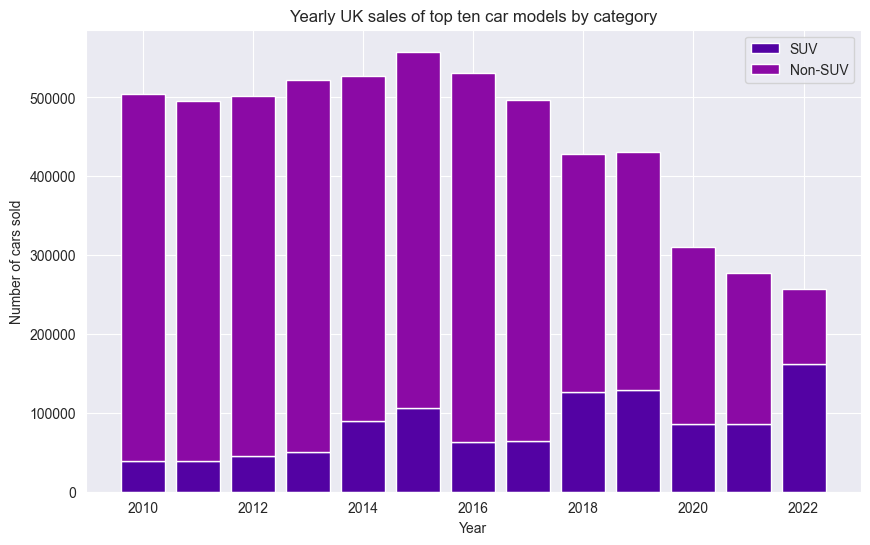

In [ ]:
# Yearly sales of SUVs and non-SUVs

# Load the car model, weight, and SUV information from Sheet 2
weight_df = pd.read_excel('Car_stats.xlsx', sheet_name='Car weight and CO2')

# Load the sales data from Sheet 1
sales_df = pd.read_excel('Car_stats.xlsx', sheet_name='Top 10 sold')

# Remove the space after 'Model' column name
sales_df = sales_df.rename(columns={'Model ': 'Model'})

# Initialize a dictionary to store the results for SUVs and non-SUVs sold each year
yearly_suv_sales = {}
yearly_non_suv_sales = {}

# Iterate through the year columns (2010 to 2023)
for year in range(2010, 2023):
    suv_cars_sold = 0
    non_suv_cars_sold = 0

    # Iterate through the rows
    for index, row in sales_df.iterrows():
        # Check if the year column has a non-null value
        if not pd.isna(row[year]):
            model = row['Model']

            # Find matching entries in weight_df
            matching_entries = weight_df[(weight_df['Model'] == model) & (weight_df['Year'] == year)]

            if not matching_entries.empty:
                is_suv = matching_entries['SUV'].values[0]

                if is_suv == 1:
                    suv_cars_sold += row[year]
                else:
                    non_suv_cars_sold += row[year]

    # Store the results for the year
    yearly_suv_sales[year] = suv_cars_sold
    yearly_non_suv_sales[year] = non_suv_cars_sold

# Create DataFrames from the dictionaries for plotting
suv_sales_df = pd.DataFrame(list(yearly_suv_sales.items()), columns=['Year', 'SUV Sales'])
non_suv_sales_df = pd.DataFrame(list(yearly_non_suv_sales.items()), columns=['Year', 'Non-SUV Sales'])

# Plot the stacked bar chart
plt.figure(figsize=(10, 6))
plt.bar(suv_sales_df['Year'], suv_sales_df['SUV Sales'], label='SUV')
plt.bar(non_suv_sales_df['Year'], non_suv_sales_df['Non-SUV Sales'], label='Non-SUV', bottom=suv_sales_df['SUV Sales'])
plt.title('Yearly UK sales of top ten car models by category')
plt.xlabel('Year')
plt.ylabel('Number of cars sold')
plt.legend()
plt.grid(True)
plt.show()


Year 2010: Average CO2 Emissions = 128.20 g/km
Year 2011: Average CO2 Emissions = 123.30 g/km
Year 2012: Average CO2 Emissions = 121.50 g/km
Year 2013: Average CO2 Emissions = 116.70 g/km
Year 2014: Average CO2 Emissions = 106.40 g/km
Year 2015: Average CO2 Emissions = 106.20 g/km
Year 2016: Average CO2 Emissions = 104.40 g/km
Year 2017: Average CO2 Emissions = 105.40 g/km
Year 2018: Average CO2 Emissions = 112.20 g/km
Year 2019: Average CO2 Emissions = 111.60 g/km
Year 2020: Average CO2 Emissions = 106.60 g/km
Year 2021: Average CO2 Emissions = 123.44 g/km
Year 2022: Average CO2 Emissions = 117.56 g/km


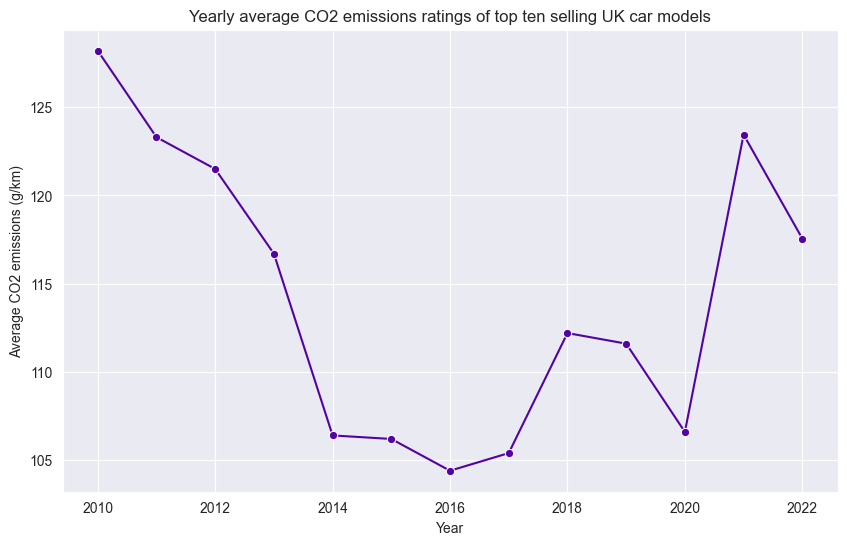

In [7]:
# Yearly average CO2 emissions ratings for top ten cars

# Load the car model and CO2 emissions information from Sheet 2
co2_df = pd.read_excel('Car_stats.xlsx', sheet_name='Car weight and CO2')

# Create a dictionary that maps (Model, Year) to CO2 emissions
car_co2_emissions = {(model, year): co2 for model, year, co2 in zip(co2_df['Model'], co2_df['Year'], co2_df['CO2'])}

# Load the sales data from Sheet 1
sales_df = pd.read_excel('Car_stats.xlsx', sheet_name='Top 10 sold')

# Initialize a dictionary to store the results
yearly_average_co2_emissions = {}

# Iterate through the year columns
for year in range(2010, 2023):  # Change 2023 to 2022
    total_co2_emissions = 0
    total_cars = 0

    # Iterate through the rows
    for index, row in sales_df.iterrows():
        model = row['Model']

        # Check if the year column has a non-null value
        if not pd.isna(row[year]):
            # Get the CO2 emissions using both model and year
            co2_emissions = car_co2_emissions.get((model, year), 0)
            total_co2_emissions += co2_emissions
            total_cars += 1

    # Calculate the average CO2 emissions for the year
    if total_cars > 0:
        average_co2_emissions = total_co2_emissions / total_cars
        yearly_average_co2_emissions[year] = average_co2_emissions

# Print the yearly average CO2 emissions
for year, co2 in yearly_average_co2_emissions.items():
    print(f'Year {year}: Average CO2 Emissions = {co2:.2f} g/km')

# Create a DataFrame from the dictionary for plotting
average_co2_df = pd.DataFrame(list(yearly_average_co2_emissions.items()), columns=['Year', 'Average CO2 Emissions'])

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_co2_df, x='Year', y='Average CO2 Emissions', marker='o')
plt.title('Yearly average CO2 emissions ratings of top ten selling UK car models')
plt.xlabel('Year')
plt.ylabel('Average CO2 emissions (g/km)')
plt.grid(True)
plt.show()


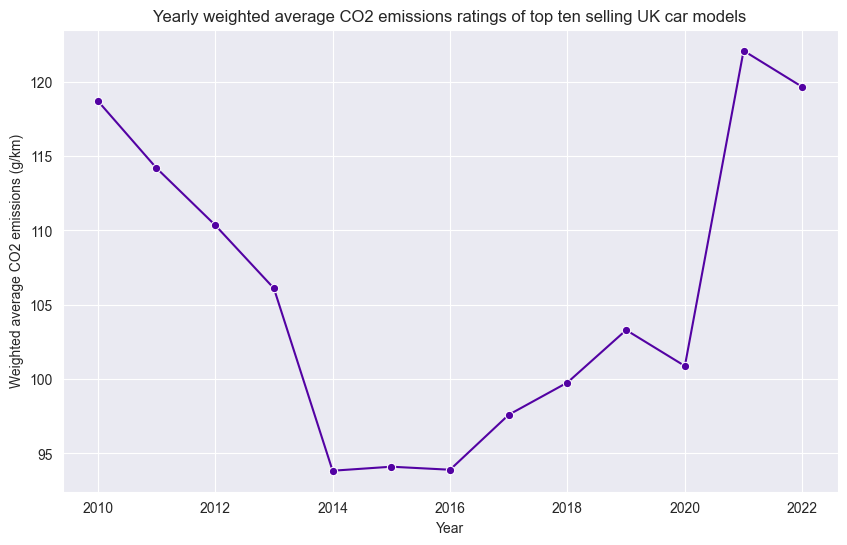

In [8]:
# # Yearly weighted average CO2 emissions ratings for top ten cars

# Load the car model and CO2 emissions information from Sheet 2
co2_df = pd.read_excel('Car_stats.xlsx', sheet_name='Car weight and CO2')

# Create a dictionary that maps (Model, Year) to CO2 emissions
car_co2_emissions = {(model, year): co2 for model, year, co2 in zip(co2_df['Model'], co2_df['Year'], co2_df['CO2'])}

# Load the sales data from Sheet 1
sales_df = pd.read_excel('Car_stats.xlsx', sheet_name='Top 10 sold')

# Initialize a dictionary to store the results
yearly_weighted_averages = {}

# Iterate through the year columns
for year in range(2010, 2023):
    total_weighted_co2_emissions = 0
    total_cars_sold = 0

    # Iterate through the rows
    for index, row in sales_df.iterrows():
        model = row['Model']

        # Check if the year column has a non-null value
        if not pd.isna(row[year]):
            # Get the CO2 emissions using both model and year
            co2_emissions = car_co2_emissions.get((model, year), 0)
            cars_sold = row[year]  # Number of cars sold for this model in this year
            total_weighted_co2_emissions += co2_emissions * cars_sold
            total_cars_sold += cars_sold

    # Calculate the weighted average CO2 emissions for the year
    if total_cars_sold > 0:
        weighted_average_co2_emissions = total_weighted_co2_emissions / total_cars_sold
        yearly_weighted_averages[year] = weighted_average_co2_emissions

# Create a DataFrame from the dictionary for plotting
weighted_average_co2_df = pd.DataFrame(list(yearly_weighted_averages.items()), columns=['Year', 'Weighted Average CO2 Emissions'])

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=weighted_average_co2_df, x='Year', y='Weighted Average CO2 Emissions', marker='o')
plt.title('Yearly weighted average CO2 emissions ratings of top ten selling UK car models')
plt.xlabel('Year')
plt.ylabel('Weighted average CO2 emissions (g/km)')
plt.grid(True)
plt.show()


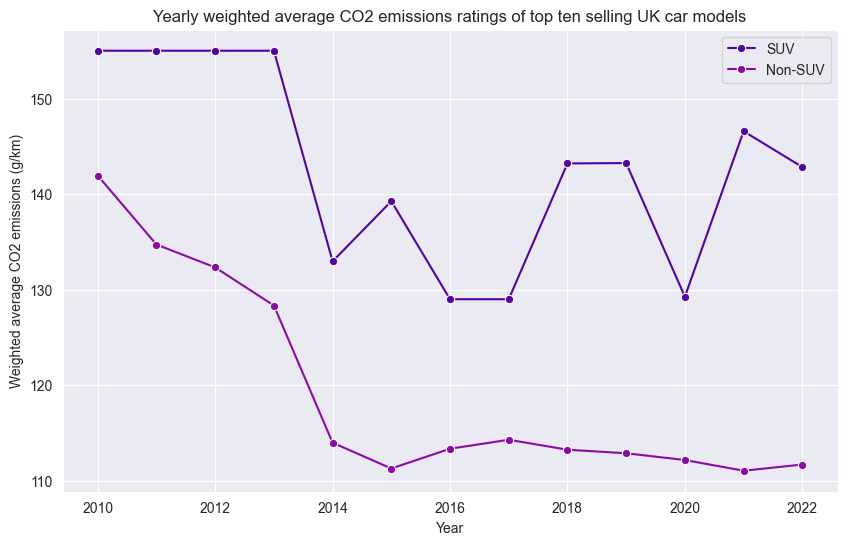

In [12]:
#Yearly weighted average CO2 emissions by category

# Load the car model and CO2 emissions information from Sheet 2
co2_df = pd.read_excel('Car_stats.xlsx', sheet_name='Car weight and CO2')

# Create a dictionary that maps (Model, Year) to CO2 emissions
car_co2_emissions = {(model, year): co2 for model, year, co2 in zip(co2_df['Model'], co2_df['Year'], co2_df['CO2'])}

# Load the sales data from Sheet 1
sales_df = pd.read_excel('Car_stats.xlsx', sheet_name='Top 10 sold')

# Initialize dictionaries to store the results for SUVs and non-SUVs
yearly_weighted_averages_suv = {}
yearly_weighted_averages_non_suv = {}

# Iterate through the year columns
for year in range(2010, 2023):
    total_weighted_co2_emissions_suv = 0
    total_cars_sold_suv = 0
    total_weighted_co2_emissions_non_suv = 0
    total_cars_sold_non_suv = 0

    # Iterate through the rows
    for index, row in sales_df.iterrows():
        model = row['Model']
        is_suv = co2_df[(co2_df['Model'] == model) & (co2_df['Year'] == year)]['SUV'].values

        # Check if the year column has a non-null value
        if not pd.isna(row[year]) and len(is_suv) > 0:
            # Get the CO2 emissions using both model and year
            co2_emissions = car_co2_emissions.get((model, year), 0)
            cars_sold = row[year]  # Number of cars sold for this model in this year

            if is_suv[0] == 1:
                total_weighted_co2_emissions_suv += co2_emissions * cars_sold
                total_cars_sold_suv += cars_sold
            else:
                total_weighted_co2_emissions_non_suv += co2_emissions * cars_sold
                total_cars_sold_non_suv += cars_sold

    # Calculate the weighted average CO2 emissions for SUVs and non-SUVs for the year
    if total_cars_sold_suv > 0:
        weighted_average_co2_emissions_suv = total_weighted_co2_emissions_suv / total_cars_sold_suv
        yearly_weighted_averages_suv[year] = weighted_average_co2_emissions_suv

    if total_cars_sold_non_suv > 0:
        weighted_average_co2_emissions_non_suv = total_weighted_co2_emissions_non_suv / total_cars_sold_non_suv
        yearly_weighted_averages_non_suv[year] = weighted_average_co2_emissions_non_suv

# Create DataFrames from the dictionaries for plotting
weighted_average_co2_df_suv = pd.DataFrame(list(yearly_weighted_averages_suv.items()), columns=['Year', 'SUV Weighted Average CO2 Emissions'])
weighted_average_co2_df_non_suv = pd.DataFrame(list(yearly_weighted_averages_non_suv.items()), columns=['Year', 'Non-SUV Weighted Average CO2 Emissions'])

# Plot the data for SUV and non-SUV
plt.figure(figsize=(10, 6))
sns.lineplot(data=weighted_average_co2_df_suv, x='Year', y='SUV Weighted Average CO2 Emissions', label='SUV', marker='o')
sns.lineplot(data=weighted_average_co2_df_non_suv, x='Year', y='Non-SUV Weighted Average CO2 Emissions', label='Non-SUV', marker='o')
plt.title('Yearly weighted average CO2 emissions ratings of top ten selling UK car models')
plt.xlabel('Year')
plt.ylabel('Weighted average CO2 emissions (g/km)')
plt.legend()
plt.grid(True)
plt.show()
